# Homework 4 - Variational Quantum Simulation

In this exercise, you will run a Variational Quantum Eignesolver simualtion of the Hydrogen (H$_2$) molecule. The goal will be to see how well the algorithm performs depending on the choice of parameterized wavefunction, or *ansatz*.

For this work, we will need to install two additional libraries, PySCF and Qiskit Nature, which provide utilities for constructing models of atoms and molecules for quantum chemistry simulaitons. Run the next cell to install these libraries.

## Part 1 - Coherence Times and Fidelity

In [3]:
from sympy.solvers import solve
from sympy import Symbol
import numpy as np

In [5]:
# Initial variable declarations
m1_T1 = 800 * pow(10, -3)
m1_T2 = 250 * pow(10, -3)
m1_GT = 100 * pow(10, -6)
m1_EPLG = 0.003

m2_T1 = 150 * pow(10, -6)
m2_T2 = 60 * pow(10, -6)
m2_GT = 80 * pow(10, -9)
m2_EPLG = 0.017

#### Question 1

In [21]:
x = Symbol('x')
e = np.e
m1_T1_pow = (-1 * m1_GT) / m1_T1
m1_T1_fidelity = float(solve(pow(e, m1_T1_pow * x) - 0.5, x)[0])
m1_T2_pow = (-1 * m1_GT) / m1_T2
m1_T2_fidelity = float(solve(pow(e, m1_T2_pow * x) - 0.5, x)[0])

m2_T1_pow = (-1 * m2_GT) / m2_T1
m2_T1_fidelity = float(solve(pow(e, m2_T1_pow * x) - 0.5, x)[0])
m2_T2_pow = (-1 * m2_GT) / m2_T2
m2_T2_fidelity = float(solve(pow(e, m2_T2_pow * x) - 0.5, x)[0])
m2_T2_fidelity

print(f"Machine 1:\nT1: {m1_T1_fidelity}\tT2: {m1_T2_fidelity}")
print(f"Machine 2:\nT1: {m2_T1_fidelity}\tT2: {m2_T2_fidelity}")

Machine 1:
T1:5545.177444479553	T2:1732.8679513998602
Machine 2:
T1:1299.650963549895	T2:519.8603854199581


#### Question 2

In [22]:
m1_2Q_fidelity = float(solve(m1_EPLG * x - 0.5, x)[0])
m2_2Q_fidelity = float(solve(m2_EPLG * x - 0.5, x)[0])
print(f"Machine 1: {m1_2Q_fidelity}")
print(f"Machine 2: {m2_2Q_fidelity}")

Machine 1: 166.66666666666666
Machine 2: 29.41176470588235


#### Question 3

Supposing that cost is no problem, machine 1 should be the obvious choice, since machine 1 has a higher amount of gate fidelity in both single qubit and 2 qubit gates. 

#### Question 4

Even if $T_{1}$ and $T_{2}$ are infinite, those are just coherence times, it doesn't mean the system is error free, since applying gates and measurements would still introduce noise to the system eventually. 

## Part 2 - Programming Exercise

In [ ]:
# Run this cell to install Qiskit Nature, which is needed for the hydrogen VQE simulation.
!pip install qiskit_nature

In [ ]:
# OPTIONAL - If you are on Mac or Linux, you can install PySCF to generate the molecular Hamiltonians
!pip install pyscf

In [2]:
import datetime as dt
import numpy as np
import qiskit as qs
import qiskit_aer as aer
from  qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, Session, IBMRuntimeError
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver, ElectronicStructureDriver

### Create a hardware backend and a noise model simulator
The VQE algorithm can take up to a hour to run on the actual quantum machine. If you're having trouble getting through the algorithm, or if the machine has a long waiting time, you may use the noise model simulator by modifying the cell below.

Set `use_simulator` to `True` or `False` depending on which backend you want to use, then run the next 3 cells.

In [4]:
use_simulator = True

In [5]:
# DO NOT MODIFY - Set up the hardware backend

service = QiskitRuntimeService()
hardware = service.backend('ibm_rensselaer')

pm = generate_preset_pass_manager(backend=hardware, optimization_level=3)

simulator = aer.AerSimulator.from_backend(hardware)

if use_simulator:
    backend = simulator

else:
    backend = hardware

In [6]:
# DO NOT MODIFY - This cell defines utility functions for timing and transpilation
def get_timestamp():
    """
    Returns the current UTC timestamp in ISO-8601 format.

    Returns
    -------
    str
    """
    return dt.datetime.now(dt.UTC).isoformat()


def transpile_and_apply(ansatz, hamiltonian, backend, optimization_level=3, passmanager=None):
    """
    Transpile the ansatz circuit and apply the Hamiltonian observable to the backend layout.
    """

    if not passmanager:
        passmanager = generate_preset_pass_manager(target=backend.target,
                                                   optimization_level=optimization_level)
    
    isa_ansatz = passmanager.run(ansatz)
    isa_hamiltonian = hamiltonian.apply_layout(isa_ansatz.layout)

    return isa_ansatz, isa_hamiltonian

## Simulation Setup
We start by defining the hydrogen molecule system according to a particular physics model defined by `PySCF`. The function defined in the next cell creates a hydrogen molecule with a bond length between the atoms, which is defined as an optional default parameter.

Once the atoms are defined, `PySCF` creates a `problem` instance from which we can extract the system Hamiltonian, which is the matrix operator that describes the physics of the molecule. This is what we will use to define the quantum measurement operator in a later step.

**Important!** If you are on Windows, PySCF is not supported outside of Windows Subsystem for Linux. If you cannot run the next cell, run the one immediately after, which has the Hamiltonian hard-coded.

In [7]:
def create_h2_molecule(bond_length=0.735):
    """
    Creates a representation of the Hamiltonian representing the physics of the
    hydrogen molecule. The bond length (in Angstroms) is provided as a
    parameter.
    """

    # Fix the first hydrogen atom at the origin.
    atom1 = f"H 0 0 {-bond_length/2}"

    # Set the Z-coordinate of the second atom using the bond length we provide
    atom2 = f"H 0 0 {bond_length/2}"

    # Join the strings in the right format to pass to the driver.
    atom = "; ".join([atom1, atom2])
    
    # Using the PySCF driver, we build the Hamiltonian that describes the
    # physics of the hydrogen molecule.
    driver = PySCFDriver(
        atom=atom,
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    # After the Hamiltonian is constructed, we extract the Hamiltonian as a
    # FermionicOp
    problem = driver.run()
    hamiltonian = problem.hamiltonian.second_q_op()

    return problem, hamiltonian

In [8]:
hamiltonian = FermionicOp({'+_0 -_0': -1.25633907300325,
                           '+_1 -_1': -0.47189600728114184,
                           '+_2 -_2': -1.25633907300325,
                           '+_3 -_3': -0.47189600728114184,
                           '+_0 +_0 -_0 -_0': 0.33785507740175813,
                           '+_0 +_1 -_1 -_0': 0.3322908651276482,
                           '+_0 +_2 -_2 -_0': 0.33785507740175813,
                           '+_0 +_3 -_3 -_0': 0.3322908651276482,
                           '+_0 +_0 -_1 -_1': 0.09046559989211572,
                           '+_0 +_1 -_0 -_1': 0.09046559989211572,
                           '+_0 +_2 -_3 -_1': 0.09046559989211572,
                           '+_0 +_3 -_2 -_1': 0.09046559989211572,
                           '+_1 +_0 -_1 -_0': 0.09046559989211572,
                           '+_1 +_1 -_0 -_0': 0.09046559989211572,
                           '+_1 +_2 -_3 -_0': 0.09046559989211572,
                           '+_1 +_3 -_2 -_0': 0.09046559989211572,
                           '+_1 +_0 -_0 -_1': 0.3322908651276482,
                           '+_1 +_1 -_1 -_1': 0.34928686136600884, 
                           '+_1 +_2 -_2 -_1': 0.3322908651276482, 
                           '+_1 +_3 -_3 -_1': 0.34928686136600884, 
                           '+_2 +_0 -_0 -_2': 0.33785507740175813, 
                           '+_2 +_1 -_1 -_2': 0.3322908651276482, 
                           '+_2 +_2 -_2 -_2': 0.33785507740175813, 
                           '+_2 +_3 -_3 -_2': 0.3322908651276482, 
                           '+_2 +_0 -_1 -_3': 0.09046559989211572, 
                           '+_2 +_1 -_0 -_3': 0.09046559989211572, 
                           '+_2 +_2 -_3 -_3': 0.09046559989211572, 
                           '+_2 +_3 -_2 -_3': 0.09046559989211572, 
                           '+_3 +_0 -_1 -_2': 0.09046559989211572, 
                           '+_3 +_1 -_0 -_2': 0.09046559989211572, 
                           '+_3 +_2 -_3 -_2': 0.09046559989211572, 
                           '+_3 +_3 -_2 -_2': 0.09046559989211572, 
                           '+_3 +_0 -_0 -_3': 0.3322908651276482, 
                           '+_3 +_1 -_1 -_3': 0.34928686136600884, 
                           '+_3 +_2 -_2 -_3': 0.3322908651276482, 
                           '+_3 +_3 -_3 -_3': 0.34928686136600884}, 
                          num_spin_orbitals=4, )

### Mapping the problem to qubits
The function defined in the next cell takes the Hamiltonian model from the `PySCF` physics driver and maps it to a Pauli gate representation using the *Jordan-Wigner Transform*. This method converts any arbitrary Hamiltonian matrix into a combination of **X**, **Y**, and **Z** operations with scalar coefficients. This is what lets us run the problem on a quantum computer.

In [9]:
def map_to_qubits(hamiltonian):
    # Create a SparsePauliOp using the Jordan-Wigner transform 
    mapper = JordanWignerMapper()
    mapped_hamiltonian = mapper.map(hamiltonian)

    return mapped_hamiltonian, mapper

### Defining an Ansatz
The ansatz of a problem is the assumed form of the quantum state that the Hamiltonian is operating on. It isn't necessarily a physical wave function, just an assumed one with parameters that we can vary.

In the next cell, we define two ansätze. The first, Unitary Coupled Cluster Singles and Doubles (UCCSD), represents a parameterized wavefunction as a unitary transformation of a reference state using an expansion of single and double excitation operators. Intuitively, this ansatz captures electron correlations by allowing electrons to be promoted from occupied to unoccupied orbitals, and in the quantum simulation, each qubit represents an orbital rather than a particle.

The second ansatz, TwoLocal, represents the wavefunction as a parameterized quantum circuit composed of alternating layers of single-qubit rotations and entangling two-qubit gates. Ths is meant to be more optimal for hardware efficiency, allowing customization of gate types and connectivity to match the capabilities of the quantum device while optimizing over adjustable parameters. In contract to UCCSD, it makes no assumptions of the underlying physics, and is entirely based on the layout of the hardware.

In [10]:
def create_ansatze(mapped_hamiltonian, mapper):

    num_spatial_orbitals = 2
    num_particles = (1, 1)
    
    uccsd_ansatz = UCCSD(num_spatial_orbitals,
                         num_particles,
                         mapper,
                         initial_state=HartreeFock(
                             num_spatial_orbitals,
                             num_particles,
                             mapper,),)

    twolocal_ansatz = TwoLocal(mapped_hamiltonian.num_qubits,        
                           rotation_blocks=["rx", "ry"],
                           entanglement_blocks=["cz"],
                           entanglement="linear",
                           reps=2,
                           initial_state=None,)

    return uccsd_ansatz, twolocal_ansatz

### Energy Function
This is the core module that constructs and executes the quantum circuit, which evaluates Schrodinger's equation, $E\psi = \textbf{H}\psi$ for the given set of parameters (in $\psi$) and fixed Hamiltonian. The end result is an expectation value that represents the ground state energy of the Hamiltonian, which in this exercise, represents the ground state energy of the Hydrogen atom.

In [11]:
def energy_function(params, ansatz, hamiltonian, estimator, session, metadata_dict):
    """
    This cost function returns the potential energy of the bond between two
    Hydrogen atoms using a qiskit estimator.

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    # Create the PUB for this parameter set
    pub = (ansatz, [hamiltonian], [params])

    # Submit the job to the session    
    job = estimator.run(pubs=[pub])

    # Grab the job ID so we can retrieve it later
    job_id = job.job_id()
    metadata_dict['job_ids'].append(job_id)

    # Wait on the result
    result = job.result()

    # Get the expectation value and std. deviation
    energy = result[0].data.evs[0]
    err = result[0].data.stds[0]


    # Keep track of the answers and statistics in the run
    metadata_dict["iters"] += 1
    metadata_dict["params"].append(params)
    metadata_dict["energy"].append((energy, err))

    if metadata_dict["iters"] >= metadata_dict["maxiter"]:
        session.close()
    
    print(f"Iters. done: {metadata_dict['iters']} [Energy: {energy} +/- {err}]")

    return energy

### VQE Algorithm
The cells below define the full VQE algorithm for both ansatze, which use the Scipy `minimize` function to run the energy function in a loop until it converges to a minimum value. The minimum value corresponds to the algorithm's estimate of the ground state energy.

In [12]:
def run_vqe_twolocal(backend, isa_twolocal, isa_hamiltonian_twolocal):

    num_params_twolocal = isa_twolocal.num_parameters
    x0_twolocal = np.zeros(num_params_twolocal)
    
    twolocal_dict = {
        'session_id': None,
        'iters': 0,
        'backend': backend.name,
        'maxiter': 200,
        'params': [],
        'energy': [],
        'job_ids': [],
        'job_info':[],
        'start_time': None,
        'end_time': None,
        'completed': False
    }
    
    with Session(backend=backend, max_time=3600) as session:
    
        # Create the estimator and assign the shot value
        estimator = Estimator(mode=session)
        estimator.options.default_precision = 1e-1
        estimator.options.resilience_level = 1
        estimator.options.default_shots = 8192
    
        try:
            # Execute the minimization
            res = minimize(
                energy_function,
                x0_twolocal,
                args=(isa_twolocal, 
                      isa_hamiltonian_twolocal, 
                      estimator, 
                      session, 
                      twolocal_dict),
                method='COBYLA',
                tol=1e-1,
            )
    
        except IBMRuntimeError:
            print("Session closed after exceeding time limit. Stopping iteration.")
    
    return twolocal_dict


In [13]:
def run_vqe_uccsd(backend, isa_uccsd, isa_hamiltonian_uccsd):

    num_params_uccsd = isa_uccsd.num_parameters
    x0_uccsd = np.zeros(num_params_uccsd)
    
    uccsd_dict = {
        'session_id': None,
        'iters': 0,
        'backend': backend.name,
        'maxiter': 200,
        'params': [],
        'energy': [],
        'job_ids': [],
        'job_info':[],
        'start_time': None,
        'end_time': None,
        'completed': False
    }
    
    with Session(backend=backend, max_time=3600) as session:
    
        # Create the estimator and assign the shot value
        estimator = Estimator(mode=session)
        estimator.options.default_precision = 1e-1
        estimator.options.resilience_level = 1
        estimator.options.default_shots = 8192
    
        try:
            # Execute the minimization
            res = minimize(
                energy_function,
                x0_uccsd,
                args=(isa_uccsd, 
                      isa_hamiltonian_uccsd, 
                      estimator, 
                      session, 
                      uccsd_dict),
                method='COBYLA',
                tol=1e-1,
            )
    
        except IBMRuntimeError:
            print("Session closed after exceeding time limit. Stopping iteration.")
    
    return uccsd_dict

## Setup the Problem
Now that we've defined all the functions, the next cell combines all of that into a problem we can run.

In [14]:
# Create the molecular model and Hamiltonian
mapped_hamiltonian, mapper = map_to_qubits(hamiltonian)

# Create the ansatze
uccsd_ansatz, twolocal_ansatz = create_ansatze(mapped_hamiltonian, mapper)

# Create the quantum circuits for each ansatz combination
isa_uccsd, isa_hamiltonian_uccsd = transpile_and_apply(uccsd_ansatz,
                                                       mapped_hamiltonian,
                                                       backend=backend,
                                                       optimization_level=3,
                                                       passmanager=pm)

isa_twolocal, isa_hamiltonian_twolocal = transpile_and_apply(twolocal_ansatz,
                                                             mapped_hamiltonian,
                                                             backend=backend,
                                                             optimization_level=3,
                                                             passmanager=pm)

## Run the TwoLocal solution
The next cell will execute the VQE algorithm using the TwoLocal ansatz. On quantum hardware, **this may take up to an hour to run**. On a simulator, it will take 5-10 minutes.

In [15]:
twolocal_results = run_vqe_twolocal(simulator, isa_twolocal, isa_hamiltonian_twolocal)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 1 [Energy: -0.06521448885228834 +/- 0.008076383486996203]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 2 [Energy: -0.32871254085701 +/- 0.011430995388059119]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 3 [Energy: -0.39854011303091885 +/- 0.014914303966937817]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 4 [Energy: -0.6170343893958272 +/- 0.01721077345495657]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 5 [Energy: -0.5926933670885575 +/- 0.01921011095969564]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 6 [Energy: -0.7248021847165627 +/- 0.017732580029028198]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 7 [Energy: -0.7513095819585299 +/- 0.018244865191687692]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 8 [Energy: -0.8450000729920168 +/- 0.018632232857097933]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 9 [Energy: -0.778165928626902 +/- 0.02017479408378477]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 10 [Energy: -1.0433407079233843 +/- 0.01843373000563237]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 11 [Energy: -1.0414566001319718 +/- 0.018817998584669118]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 12 [Energy: -1.1875166405331246 +/- 0.017984005528309626]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 13 [Energy: -1.0515121118881874 +/- 0.01945053781821391]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 14 [Energy: -1.2194775960745132 +/- 0.017862864008430658]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 15 [Energy: -1.1288425969532283 +/- 0.018534931090871693]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 16 [Energy: -1.2438210641377692 +/- 0.01771462355216227]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 17 [Energy: -1.1435789378137229 +/- 0.01921083172160541]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 18 [Energy: -1.367457715327757 +/- 0.017352118342333963]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 19 [Energy: -1.284838880451483 +/- 0.017920720568339456]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 20 [Energy: -1.4554881173820544 +/- 0.01675558096523141]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 21 [Energy: -1.2784266976532848 +/- 0.018574171084215888]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 22 [Energy: -1.316990291420446 +/- 0.017797908923828272]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 23 [Energy: -1.4348352189818387 +/- 0.016865182007238518]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 24 [Energy: -1.3153426397146126 +/- 0.017928501234142375]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 25 [Energy: -1.3122270985419082 +/- 0.018619955834004075]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 26 [Energy: -1.322005900969287 +/- 0.018743373531058715]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 27 [Energy: -1.3311990578915534 +/- 0.01776625035083055]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 28 [Energy: -1.4429300962916958 +/- 0.0170274437285354]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 29 [Energy: -1.4235170590675505 +/- 0.017723351923731433]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 30 [Energy: -1.399063362880367 +/- 0.017370183392996123]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 31 [Energy: -1.3414852130727617 +/- 0.017718355296577733]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 32 [Energy: -1.5297098479220412 +/- 0.01590617075412901]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 33 [Energy: -1.488494701683013 +/- 0.016921134679943148]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 34 [Energy: -1.5366137886681068 +/- 0.016355270265079134]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 35 [Energy: -1.584638386125643 +/- 0.016282894947683577]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 36 [Energy: -1.577056760081671 +/- 0.015835575249151284]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 37 [Energy: -1.5723244604552105 +/- 0.01684619827680657]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 38 [Energy: -1.5120554914424604 +/- 0.016671432678024456]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 39 [Energy: -1.568452268749112 +/- 0.016684141786638438]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 40 [Energy: -1.4396877193046171 +/- 0.01789114256908082]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 41 [Energy: -1.5565965543527007 +/- 0.01690462389451846]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 42 [Energy: -1.3809774441596772 +/- 0.018803768119622213]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 43 [Energy: -1.5130125812684907 +/- 0.017222797739372724]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 44 [Energy: -1.553693023588334 +/- 0.016172180193365304]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 45 [Energy: -1.5668341930635452 +/- 0.016689041127260218]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 46 [Energy: -1.5702871745640639 +/- 0.01625002531829391]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 47 [Energy: -1.551414970411931 +/- 0.016759018521987093]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 48 [Energy: -1.5835855702219077 +/- 0.016233074435883118]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 49 [Energy: -1.5813390435759462 +/- 0.016500774805615768]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 50 [Energy: -1.5697678010670721 +/- 0.016636098172181767]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 51 [Energy: -1.544321724976241 +/- 0.016731365780219776]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 52 [Energy: -1.573002391031561 +/- 0.01647503183370317]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 53 [Energy: -1.5246114699722786 +/- 0.017074256216112294]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 54 [Energy: -1.568606590005845 +/- 0.01670713549344946]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 55 [Energy: -1.4674441819156991 +/- 0.017990835833118075]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 56 [Energy: -1.5793840063826847 +/- 0.016408598689686176]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 57 [Energy: -1.5782527794968484 +/- 0.01638531304290658]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 58 [Energy: -1.5745561694991277 +/- 0.016588445180976887]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 59 [Energy: -1.6292358665499271 +/- 0.015058045800306633]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 60 [Energy: -1.6479492863226757 +/- 0.0147627405081937]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 61 [Energy: -1.667592312416946 +/- 0.014253725262352647]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 62 [Energy: -1.6792747054309867 +/- 0.013638262991962687]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 63 [Energy: -1.6777086570381121 +/- 0.013749725882728185]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 64 [Energy: -1.6992831935026096 +/- 0.013002501704449144]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 65 [Energy: -1.6925214532220754 +/- 0.013316700363844186]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 66 [Energy: -1.6693540303718046 +/- 0.01374130307548832]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 67 [Energy: -1.6917234408085662 +/- 0.013189223924952469]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 68 [Energy: -1.6776671066550768 +/- 0.01345528120806211]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 69 [Energy: -1.7080467981940708 +/- 0.012669495805030075]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 70 [Energy: -1.7273835195166767 +/- 0.011995545950987157]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 71 [Energy: -1.7265320686702368 +/- 0.011945519353998978]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 72 [Energy: -1.7195401440073539 +/- 0.012353168734146214]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 73 [Energy: -1.7393237455711128 +/- 0.0114180376898884]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 74 [Energy: -1.7381358803481004 +/- 0.01141695374088968]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 75 [Energy: -1.7360538418293714 +/- 0.011722236251472867]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 76 [Energy: -1.7296199573873434 +/- 0.011902015886653058]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 77 [Energy: -1.7247137879032326 +/- 0.011947565487583856]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 78 [Energy: -1.7336711745327287 +/- 0.011748815151040813]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 79 [Energy: -1.7313499974809774 +/- 0.011435502790807938]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 80 [Energy: -1.73750276855294 +/- 0.01150834884751562]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 81 [Energy: -1.7343018565348474 +/- 0.011488688519849211]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 82 [Energy: -1.7307555650122461 +/- 0.01168922566422923]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 83 [Energy: -1.7481162060566513 +/- 0.011106294686709565]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 84 [Energy: -1.7449654042836102 +/- 0.011352490478252406]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 85 [Energy: -1.7573958313745897 +/- 0.01071929746049047]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 86 [Energy: -1.7581706564626585 +/- 0.010571506705342999]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 87 [Energy: -1.7395895433912976 +/- 0.010765280132773435]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 88 [Energy: -1.7522851208844807 +/- 0.010809624387943645]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 89 [Energy: -1.7567674568583325 +/- 0.010567787788163835]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 90 [Energy: -1.756852367395254 +/- 0.010481413762605031]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 91 [Energy: -1.762777702148765 +/- 0.010297370936885984]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 92 [Energy: -1.7616912017215265 +/- 0.010319454534603792]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 93 [Energy: -1.7577724732499982 +/- 0.010421380644721727]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 94 [Energy: -1.7622334880916162 +/- 0.010164512575659477]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 95 [Energy: -1.7517045362780674 +/- 0.010735173352114616]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 96 [Energy: -1.7549002225668162 +/- 0.010609723511933159]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 97 [Energy: -1.7531030055121202 +/- 0.010803300786081299]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 98 [Energy: -1.754851099408037 +/- 0.010512270709397361]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 99 [Energy: -1.7417435407845052 +/- 0.011119021902711572]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 100 [Energy: -1.7511628203511562 +/- 0.010600244699445498]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 101 [Energy: -1.767921491951178 +/- 0.00984816206331463]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 102 [Energy: -1.7730677349845345 +/- 0.009614107891888908]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 103 [Energy: -1.7351371997738267 +/- 0.011249829403120337]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 104 [Energy: -1.7681605883745193 +/- 0.00985898213369972]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 105 [Energy: -1.7694280050161997 +/- 0.009877945943245675]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 106 [Energy: -1.7740933577345315 +/- 0.009671211075913745]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 107 [Energy: -1.7593088957147425 +/- 0.010412359526621198]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 108 [Energy: -1.7746666146972534 +/- 0.009683800092259415]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 109 [Energy: -1.7702026311697443 +/- 0.009622019333304341]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 110 [Energy: -1.766638133347596 +/- 0.009982897735912773]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 111 [Energy: -1.7724035721909464 +/- 0.009530237003338318]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 112 [Energy: -1.7711048644477851 +/- 0.009642278148421427]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 113 [Energy: -1.7687824593135133 +/- 0.009957873089360858]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 114 [Energy: -1.7702747916090595 +/- 0.009827456940884454]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 115 [Energy: -1.7649677679642788 +/- 0.010106241095103389]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 116 [Energy: -1.7748293110438202 +/- 0.0097218749562066]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 117 [Energy: -1.7675631925697655 +/- 0.010006636579979751]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 118 [Energy: -1.7684804212267362 +/- 0.00989729156572165]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 119 [Energy: -1.7707377421675345 +/- 0.009780247535261816]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 120 [Energy: -1.7716257817069578 +/- 0.009905416731598527]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 121 [Energy: -1.7644834858818859 +/- 0.010215083609957988]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 122 [Energy: -1.7732030722820593 +/- 0.00969762417597536]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 123 [Energy: -1.770606748949846 +/- 0.009849100722393433]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 124 [Energy: -1.7723680746494397 +/- 0.009722098192767889]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 125 [Energy: -1.7680068476166126 +/- 0.010068356662803422]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 126 [Energy: -1.77555584989 +/- 0.009485067414776449]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 127 [Energy: -1.7747556440188583 +/- 0.009636765427044459]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 128 [Energy: -1.7780912690883155 +/- 0.00944455065679641]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 129 [Energy: -1.7743590895780303 +/- 0.009660916748076422]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 130 [Energy: -1.7720609946036536 +/- 0.009887119743130503]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 131 [Energy: -1.773445879436212 +/- 0.00962080224262342]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 132 [Energy: -1.7757862334550194 +/- 0.009509575466614042]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 133 [Energy: -1.780868757408266 +/- 0.009305695559127056]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 134 [Energy: -1.780157658132874 +/- 0.009342910854134643]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 135 [Energy: -1.7782327095473824 +/- 0.009387145630571192]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 136 [Energy: -1.7802669624286964 +/- 0.009374824266018714]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 137 [Energy: -1.7822192503443481 +/- 0.009151990097252118]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 138 [Energy: -1.7759532946467744 +/- 0.009401769219924066]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 139 [Energy: -1.7806724003935621 +/- 0.009260997303325257]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 140 [Energy: -1.7801032919647393 +/- 0.009444551391372315]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 141 [Energy: -1.7787985828710304 +/- 0.009320810616187931]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 142 [Energy: -1.7820676941941433 +/- 0.009147106463043049]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 143 [Energy: -1.781458967248546 +/- 0.009221667487066135]


## Run the UCCSD Solution
The next cell will solve the VQE problem for the UCCSD ansatz. On quantum hardware, **this may take up to an hour to run**. On a simulator, it will take 5-10 minutes.

In [16]:
uccsd_results = run_vqe_uccsd(simulator, isa_uccsd, isa_hamiltonian_uccsd)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 1 [Energy: -1.6652449596332302 +/- 0.012763715604033629]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 2 [Energy: -1.190161009394095 +/- 0.01729320736501413]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 3 [Energy: -1.2406494900694547 +/- 0.016642115089079774]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 4 [Energy: -0.6431068999669196 +/- 0.01587158292206731]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 5 [Energy: -1.1695075557497503 +/- 0.018686679686000032]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 6 [Energy: -1.528750396864856 +/- 0.015847576890395298]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 7 [Energy: -1.6471843061289977 +/- 0.014223780879177533]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 8 [Energy: -1.6657067046333318 +/- 0.013148461975119267]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 9 [Energy: -1.5564185264678434 +/- 0.014092495168572606]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 10 [Energy: -1.670836175348069 +/- 0.013397642714203364]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 11 [Energy: -1.6494468882532316 +/- 0.014106250583630832]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


Iters. done: 12 [Energy: -1.6619710008160649 +/- 0.01359471890682909]


### Compare to the Reference Value
We can use `numpy.linalg.eigh` to find the ground state of the Hamiltonian directly, since hydrogen is small enough to be solved classically. We use this as the reference value to compare our quantum results to.

In [17]:
ham = mapped_hamiltonian.to_matrix()
reference_energy = np.linalg.eigh(ham)[0][0]

uccsd_energy, uccsd_err = uccsd_results['energy'][-1]
twolocal_energy, twolocal_err = twolocal_results['energy'][-1]

print(f'Reference Energy: {reference_energy} eV')
print(f'UCCSD Energy: {uccsd_energy} eV')
print(f'TwoLocal Energy: {twolocal_energy} eV')

Reference Energy: -1.8572750302023795 eV
UCCSD Energy: -1.6619710008160649 eV
TwoLocal Energy: -1.781458967248546 eV


### Plot the Result
The cell below plots the results of the two quantum calculations alongside the reference energy for comparison.

<ErrorbarContainer object of 3 artists>

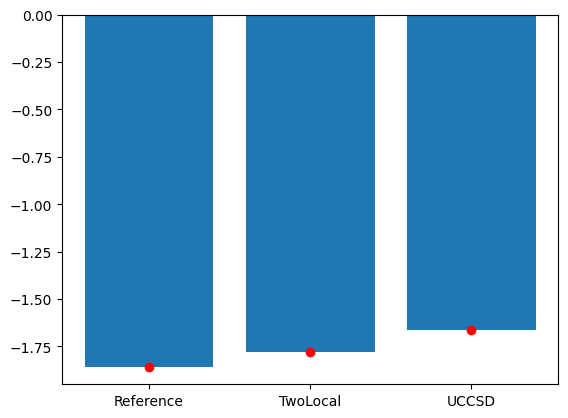

In [18]:
xvals = ["Reference", "TwoLocal", "UCCSD"]
yvals = [reference_energy, twolocal_energy, uccsd_energy]
yerr = [0, twolocal_err, uccsd_err]

plt.bar(xvals, yvals)
plt.errorbar(xvals, yvals, yerr, fmt="o", color="r")

#### Question 1
Run the cells in the Jupyter notebook to get the estimated ground state energy for H2 using
the UCCSD and TwoLocal ansatze. Report your answers along with the reference answer.

Reference Energy: -1.8572750302023795 eV

UCCSD Energy: -1.6619710008160649 eV

TwoLocal Energy: -1.781458967248546 eV

#### Question 2
How do your answers for the two quantum calculations compare to the reference answer?

They are both less than the reference value.

#### Question 3
Does one ansatz give an answer closer to the reference value over the other? Which one? Why
might this be?

The twolocal answer gives a closer value to the reference, and the reason for that might be due to the greater number of iterations done. That would result in a closer answer given that any Monte Carlo simulation would get closer to the true answer the more iterations it has.

#### Question 4
Define the terms ansatz and Hamiltonian. What does each one represent in the simulation?

Ansatz is German for "an educated guess". In science, it is an initial assumption that's used to solve a problem. A Hamiltonian represents the total energy of a system. In the simulation, the ansatz represents the initial guess of what the energy is would end up looking like, and the Hamiltonian is the total energy state of the hydrogen atom. 

#### Question 5
You are leading a quantum research team performing ground state calculations of a complex molecule. You just ran this $H_{2}$ simulation as a benchmark to inform what ansatz you should pick for the bigger calculation. What ansatz would you choose if your team is prioritizing
cost-effectiveness? Why?

The UCCSD ansatz would be used for cost-effectivness, since it managed to roughly approximate the energy levels of $H_{2}$ with only 12 iterations, as opposed to twolocal's 143 iterations. 

## Part 3 - Free Response: Project Proposal

Team members: Jeremy Chen, Nathaniel Depue, Nate Mirin, Sameer Premji

Our group is planning on creating a grant proposal for making a quantum sensor. The plan is to, at the very least, by the time project 2 is due, to a have a fully outline proposal for a making a quantum sensor. We wish to approach professor Tom Haley for a grant, and moving forward from there.

As for contribution, I will be handling the information analysis part of the quantum sensor. Since the information gathered from the sensor would be messy and needs to be parsed, an algorithm for processes like denoising and squeezing. Though I don't know how that will be accomplished right now, my idea is to have the input be a sequence of signal strengths to be plotted, and that data will be crunch and processed afterwards with some sort of Python library. 